# Kadlu demo :  "The Gully"

In this little demo, we will demonstrate how the Kadlu Python package can be used to model underwater sound propagation. For this purpose, we will use realistic environmental data from a marine area located 200 km off the coast of Nova Scotia known as the The Gully.

### Facts about The Gully

"The Gully is located approximately 200 kilometres off Nova Scotia to the east of Sable Island on the edge of the Scotian Shelf. Over 65 kilometres long and 15 kilometres wide, the Gully is the largest underwater canyon in the western North Atlantic. The movement of glaciers and meltwater erosion formed the canyon approximately 150,000 to 450,000 years ago, when much of the continental shelf was above the current sea level.

The Gully ecosystem encompasses shallow sandy banks, a deep-water canyon environment, and portions of the continental slope and abyssal plain, providing habitat for a wide diversity of species. The Gully’s size, shape, and location have an effect on currents and local circulation patterns, concentrating nutrients and small organisms within the canyon.

The Gully is home to the endangered Scotian Shelf population of Northern bottlenose whales and is an important habitat for 15 other species of whales and dolphins. Tiny plankton, a variety of fish such as sharks, tunas and swordfish, and seabirds inhabit surface waters, while halibut, skates, cusk and lanternfish can be found as deep as one kilometre. The ocean floor supports crabs, sea pens, anemones, brittle stars, and approximately 30 species of cold-water."

(Source: www.dfo-mpo.gc.ca)

<img src="gully.jpg" width="480" height="480" align="left"/>

Import all the necessary stuff (nevermind the warning),

In [1]:
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
from kadlu.sound.sound_propagation import TLCalculator, Seafloor
from kadlu.geospatial.ocean import Ocean

/home/oliskir/src/anaconda3/envs/kadlu_env/lib/python3.6/site-packages/kadlu/geospatial/data_sources/data_util.py:43: UserWarning: missing kadlu/config.ini. storage location will be set to /home/oliskir/src/anaconda3/envs/kadlu_env/lib/python3.6/site-packages/storage/
  warnings.warn(f"{msg} storage location will be set to {storage_location}")
/home/oliskir/src/anaconda3/envs/kadlu_env/lib/python3.6/site-packages/kadlu/geospatial/data_sources/data_util.py:43: UserWarning: missing kadlu/config.ini. storage location will be set to /home/oliskir/src/anaconda3/envs/kadlu_env/lib/python3.6/site-packages/storage/
  warnings.warn(f"{msg} storage location will be set to {storage_location}")


### Environmental data

We proceed to fetching and loading the environmental data. This is accomplished with the Ocean class, as shown below. We fetch bathymetry data from the Canadian Hydrographic Service ([CHS](https://open.canada.ca/data/en/dataset/d3881c4c-650d-4070-bf9b-1e00aabf0a1d)) and temperature/salinity data from the HYbrid Coordinate Ocean Model ([HYCOM](https://www.hycom.org/)). We specify the geographic region as extending from 43.53 degrees south to 44.29 degrees north and -59.84 degrees west to -58.48 degrees east. Moreover, we specify a time period (only relevant for temp/salinity) of 1 day from 2015.01.01 to 2015.01.02. Note that all the data is fetched online.

In [8]:
ocean_gully = Ocean(default=False, cache=True, fetch=True, 
                    load_bathymetry='chs', 
                    #load_temp='hycom', 
                    #load_salinity='hycom',
                    south=43.53, north=44.29, 
                    west=-59.84, east=-58.48,
                    start=datetime(2015,1,1), 
                    end=datetime(2015,1,2))


CA2_4400N06000W.tif: downloading 4/4 from CHS NONNA-100...
CA2_4300N05900W.tif processed and inserted 0 rows.	798620 null values removed, 203381 duplicate rows ignored
CA2_4300N06000W.tif processed and inserted 0 rows.	967380 null values removed, 34621 duplicate rows ignored
CA2_4400N05900W.tif processed and inserted 0 rows.	973710 null values removed, 28291 duplicate rows ignored
CA2_4400N06000W.tif processed and inserted 0 rows.	954562 null values removed, 47439 duplicate rows ignored


In order to accurately model underwater sound propagation, we also need data on the acoustic properties of the seafloor. (How much sound does it reflect, how much does it absorb, etc.) Functions for automatically fetching this information from online sources have not yet been implemented in Kadlu (although we are working on this), so for now we specify this manually. Here, we specify the following properties for the seafloor: thickness of 100, sound speed of 1,700 m/s, density of 1.5 g/cm^3, and attenuation of 0.5 dB per wavelength.

In [3]:
seafloor_gully = Seafloor(thickness=500, c=1700, density=1.5, loss=0.5)

Let us take a look at the environmental data we have loaded for the Gully.

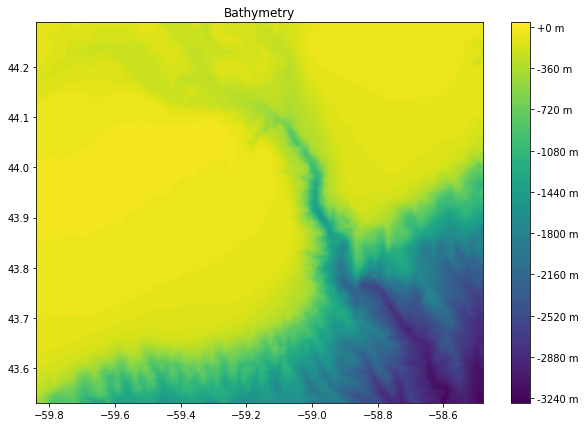

In [35]:
# create axes
lat   = np.linspace(43.53, 44.29, 100)
lon   = np.linspace(-59.84, -58.48, 100)

# interpolate bathy, temp, salinity
bathy    = ocean_gully.bathy(lat=lat, lon=lon, grid=True)
temp     = ocean_gully.temp(lat=lat, lon=lon, z=[-10], grid=True)      #temp at 10m depth
salinity = ocean_gully.salinity(lat=lat, lon=lon, z=[-10], grid=True)  #salinity at 10m depth

# draw bathymetry
plt.figure(figsize=(10,7))
plt.contourf(lon, lat, bathy, 100)
plt.colorbar(format='%+2.0f m')
plt.title('Bathymetry')
plt.show()

### Transmission loss

The transmission loss is a measure of reduction in sound intensity. We use Kadlu's TLCalculator to determine the transmission loss, as show below. 

In [38]:
# initialize an instance of the TLCalculator class
tl = TLCalculator(ocean=ocean_gully, 
                  seafloor=seafloor_gully, 
                  sound_speed=1500,
                  radial_bin=100, radial_range=50e3,
                  angular_bin=10, angular_range=10,
                  vertical_bin=10, 
                  verbose=False,
                  progress_bar=True)

We place a sound source about 10 km west of the Gully, 2 m below the sea surface, and set its frequency to 200 Hz. 

In [39]:
tl.run(frequency=200, source_depth=-2, source_lat=43.9, source_lon=-59.2, vertical_slice=True)

  0%|          | 0/500 [00:00<?, ?it/s]/home/oliskir/src/anaconda3/envs/kadlu_env/lib/python3.6/site-packages/kadlu/sound/pe/propagator.py:225: RuntimeWarning: overflow encountered in cosh
  sech2 = 1. / np.cosh(0.5 * h / ld)
100%|██████████| 500/500 [00:05<00:00, 92.11it/s]


Finally, we plot the transmission loss along a radial transect.

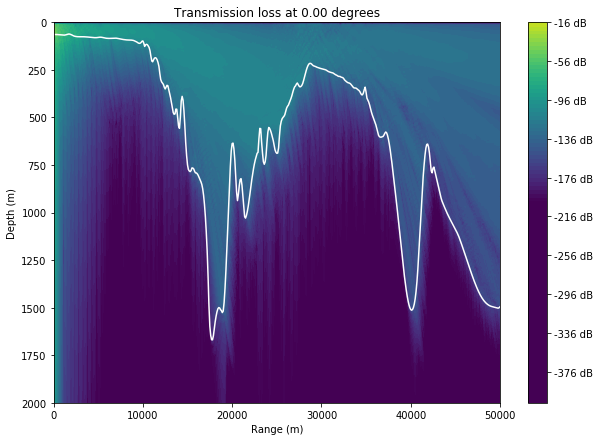

In [43]:
fig = tl.plot_vertical(angle=0, show_bathy=True, figsize=(10,7), dB_range=(-200,0))